In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:
# サブルーチン一式

# 日付毎の24時の台数のテーブルを作る
# station_id            ステーションID
# date                  日付
# bikes_available_at0   0時の自転車台数
def get_bikes_available_at0(status):
    bikes_available_at0 = status.groupby(['station_id', 'date']).first()['bikes_available'].reset_index()
    bikes_available_at0.columns = ['station_id', 'date', 'bikes_available_at0']
    return bikes_available_at0

# 0時の自転車台数とその差分を作成
def get_diff_available_at0(status, bikes_available_at0):
    # 0時の自転車台数もくっつける
    status = pd.merge(status, bikes_available_at0, on=['station_id', 'date'], how='left')
    # 各時刻で0時の自転車台数との差分を見る
    status['deltaAt0'] = status['bikes_available'] - status['bikes_available_at0']
    return status

#statusの取得と整形
# id            そのまま
# year          年
# month         月
# day           日
# hour          時
# station_id    ステーションID
# bikes_available    利用可能な自転車台数
# predict       予測対象かどうか
# date          yyyy-mm-dd
# date_hour     yyyy-mm-dd-hh ※mergeとか整列に便利！ 
# weekday       曜日[0:月曜日・・・6:日曜日]
# TODO:変更してる部分の追加
def get_status(filename):
    status = pd.read_csv(filename)
    status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str)
    status['date'] = pd.to_datetime(status['date'])
    status['date_hour'] = status['date'].astype(str) + '-' + status['hour'].astype(str).str.zfill(2).astype(str)
    status['weekday'] = status['date'].dt.weekday

    # 当日0時のデータを取得して、マージ。ついでに0時との台数の差分を追加。
    bikes_available_at0 = get_bikes_available_at0(status)
    status = get_diff_available_at0(status, bikes_available_at0)

    # 1時間前の利用可能台数
    status['pre_bikes_available'] = status['bikes_available'].shift(1)
    # 1時間前の利用可能台数との差分
    status['diff_bikes_available'] = status['bikes_available'] - status['pre_bikes_available']
    #status = status[status['date_hour'] != '2013-09-01-00']

    return status

# stationとcityの関連テーブルを作る
def get_station(filename):
    station = pd.read_csv(filename)
    station = station[['station_id', 'city']]
    return station

#tripの取得と整形
# trip_id           そのまま
# duration          移動時間
# start_date        yyyy-mm-dd hh:mm:ss 出発日
# start_station_id  出発ステーションID
# end_date          yyyy-mm-dd hh:mm:ss 到着日
# end_station_id    到着ステーションID
# bike_id           自転車のID
# subscription_type 利用タイプ 
# start_hour        h 出発時間
# start_day         yyyy-mm-dd 出発日
# end_hour          h 到着時間
# end_day           yyyy-mm-dd 到着日
# start_date_hour   yyyy-mm-dd-hh 出発時刻
# end_date_hour     yyyy-mm-dd-hh 到着時刻
def get_trip(filename):
    trip = pd.read_csv(filename)
    # datetime型に変換
    trip['start_date'] = pd.to_datetime(trip['start_date']) + datetime.timedelta(hours=1) # データを1時間ずらしておく。1時間前の到着時刻などを使うので。
    trip['end_date'] = pd.to_datetime(trip['end_date']) + datetime.timedelta(hours=1)     # データを1時間ずらしておく。1時間前の到着時刻などを使うので。
    trip['start_hour'] = trip['start_date'].dt.hour
    trip['start_day'] = pd.to_datetime(trip['start_date'].dt.date)
    trip['end_hour'] = trip['end_date'].dt.hour
    trip['end_day'] = pd.to_datetime(trip['end_date'].dt.date)
    trip = trip[trip['start_day'] >= '2013-09-01']
    trip = trip[trip['end_day'] >= '2013-09-01']
    trip['start_date_hour'] = trip['start_day'].astype(str) + '-' + trip['start_hour'].astype(str).str.zfill(2).astype(str)
    trip['end_date_hour'] = trip['end_day'].astype(str) + '-' + trip['end_hour'].astype(str).str.zfill(2).astype(str)
    return trip

def get_used(trip):
    # tripのgrouping
    df_start_id_hour = trip.groupby(['start_date_hour', 'start_station_id']).size().reset_index()
    df_start_id_hour = df_start_id_hour.rename(columns={'start_date_hour': 'date_hour', 'start_station_id': 'station_id', 0: 'start_num'})
    df_end_id_hour = trip.groupby(['end_date_hour', 'end_station_id']).size().reset_index()
    df_end_id_hour = df_end_id_hour.rename(columns={'end_date_hour': 'date_hour', 'end_station_id': 'station_id', 0: 'end_num'})

    # 出発と到着をくっつける
    df_start_end_id_hour = pd.merge(df_start_id_hour, df_end_id_hour, on=['date_hour', 'station_id'], how='outer').fillna(0)

    # 出発と到着の差分を求める
    df_start_end_id_hour['delta_num'] = df_start_end_id_hour['end_num'] - df_start_end_id_hour['start_num']
    df_start_end_id_hour['delta_num'] = df_start_end_id_hour['delta_num'].fillna(0)
    return df_start_end_id_hour

# 天気の取得
def get_weather(filename):
    weather = pd.read_csv(filename)
    weather = weather[['date', 'precipitation', 'events']] # 絞る
    weather_le = LabelEncoder()
    weather['events'] = weather_le.fit_transform(weather['events'])
    weather['date'] = pd.to_datetime(weather['date'])
    weather.fillna(0)
    #print(weather_le.classes_)
    return weather


In [4]:
# 処理の開始はここから。
# まずはデータの取得と整形

#statusの取得と整形
df_status = get_status('org/status.csv')
print('---------- df_status ----------')
print(df_status.head(1))

# stationとcityの関連を取得
df_station_city = get_station('org/station.csv')
#print('---------- df_station_city ----------')
#print(df_station_city.head(1))

# 出発、到着、差分を取得する。
df_trip = get_trip('org/trip.csv')
df_used = get_used(df_trip)
#print('---------- df_used ----------')
#print(df_used.head(1))

# 天気を取得
df_weather = get_weather('org/weather.csv')
#print('---------- df_weather ----------')
#print(df_weather.head(1))


---------- df_status ----------
   id  year  month  day  hour  station_id  bikes_available  predict  \
0   0  2013      9    1     0           0             11.0        0   

        date      date_hour  weekday  bikes_available_at0  deltaAt0  \
0 2013-09-01  2013-09-01-00        6                 11.0       0.0   

   pre_bikes_available  diff_bikes_available  
0                  NaN                   NaN  


In [5]:
# statusにいろいろくっつける
df_status_merged = pd.merge(df_status, df_used, on=['date_hour', 'station_id'], how='left').sort_values(['station_id', 'date_hour'])
df_status_merged = pd.merge(df_status_merged, df_station_city, on=['station_id'], how='left')
df_status_merged = pd.merge(df_status_merged, df_weather, on=['date'], how='left')

df_status_merged.to_csv('df_status_merged.csv')
df_status_merged.head(1)

id  year  month  day  hour  station_id  bikes_available  predict  \
0   0  2013      9    1     0           0             11.0        0   

        date      date_hour  ...  bikes_available_at0  deltaAt0  \
0 2013-09-01  2013-09-01-00  ...                 11.0       0.0   

   pre_bikes_available  diff_bikes_available  start_num  end_num  delta_num  \
0                  NaN                   NaN        NaN      NaN        NaN   

    city precipitation  events  
0  city1           0.0       3  

[1 rows x 21 columns]

In [8]:
# 各ステーション・曜日・時刻の出発と到着の平均値を求める
df_status_merged_inout = df_status_merged[df_status_merged['date'] < '2014-09-01']
df_inout_group = df_status_merged_inout.groupby(['station_id', 'hour', 'weekday']).mean(numeric_only=True).reset_index()
df_inout_group = df_inout_group[['station_id', 'hour', 'weekday', 'start_num', 'end_num']].fillna(0)
df_status_merged_for_input = pd.merge(df_status_merged, df_inout_group, on=['station_id', 'hour', 'weekday'], how='left', suffixes=['', '_ave'])
df_status_merged_for_input.head(5)

id  year  month  day  hour  station_id  bikes_available  predict  \
0   0  2013      9    1     0           0             11.0        0   
1   1  2013      9    1     1           0             11.0        0   
2   2  2013      9    1     2           0             11.0        0   
3   3  2013      9    1     3           0             11.0        0   
4   4  2013      9    1     4           0             11.0        0   

        date      date_hour  ...  pre_bikes_available  diff_bikes_available  \
0 2013-09-01  2013-09-01-00  ...                  NaN                   NaN   
1 2013-09-01  2013-09-01-01  ...                 11.0                   0.0   
2 2013-09-01  2013-09-01-02  ...                 11.0                   0.0   
3 2013-09-01  2013-09-01-03  ...                 11.0                   0.0   
4 2013-09-01  2013-09-01-04  ...                 11.0                   0.0   

   start_num  end_num  delta_num   city  precipitation  events start_num_ave  \
0        NaN      NaN        NaN  city1            0.0       3      0.875000   
1        NaN      NaN        NaN  city1            0.0       3      1.000000   
2        NaN      NaN        NaN  city1            0.0       3      1.090909   
3        NaN      NaN        NaN  city1            0.0       3      0.000000   
4        NaN      NaN        NaN  city1            0.0       3      0.000000   

   end_num_ave  
0     0.250000  
1     0.500000  
2     0.181818  
3     1.000000  
4     0.000000  

[5 rows x 23 columns]

In [7]:
# データの分析
# 0時の各駅のデータをくっつける予定
# ステーションごとに相関を求める
# 相関が高い上位5ステーションを推測に加える
df_at0_target_st_corr_all = pd.DataFrame([], columns=['date', 'station_id', 'hour', 'at0_st1', 'at0_st2', 'at0_st3', 'at0_st4', 'at0_st5'])
for target_st in range(0, 70):
    print('station:' + str(target_st))
    for hour in range(0, 24):
        df_at0_target_st = df_status_merged[(df_status_merged['station_id'] == target_st) & (df_status_merged['hour'] == hour)]
        df_at0_target_st = df_at0_target_st[['date', 'bikes_available']]
        # ある時刻の全日付・全ステーションのbikes_available_at0
        for st in range(0, 70):
            df_at0_st = df_status_merged[df_status_merged['station_id'] == st]
            df_at0_st = df_at0_st[df_at0_st['hour'] == hour]
            df_at0_st = df_at0_st[['date', 'bikes_available_at0']]
            df_at0_st = df_at0_st.rename(columns={'bikes_available_at0': st})
            df_at0_target_st = pd.merge(df_at0_target_st, df_at0_st, on=['date'], how='left')
        
        # 上位5位のステーションを求める
        df_at0_target_st_corr = df_at0_target_st.corr(numeric_only = True)
        df_at0_target_st_corr = df_at0_target_st_corr['bikes_available']
        df_at0_target_st_corr = df_at0_target_st_corr.abs().sort_values(ascending=False)
        at0_st = df_at0_target_st_corr.keys()
        # ステーション番号から、0時の台数を取り出す。                                               
        df_at0_target_st_corr = df_at0_target_st[['date', at0_st[2], at0_st[3], at0_st[4], at0_st[5], at0_st[6]]]
        df_at0_target_st_corr = df_at0_target_st_corr.rename(columns={at0_st[2]: 'at0_st1', at0_st[3]: 'at0_st2', at0_st[4]: 'at0_st3', at0_st[5]: 'at0_st4', at0_st[6]: 'at0_st5'})
        # ステーションIDと時間をくっつける
        df_at0_target_st_corr['station_id'] = target_st
        df_at0_target_st_corr['hour'] = hour
        df_at0_target_st_corr_all = pd.concat([df_at0_target_st_corr_all, df_at0_target_st_corr])
# 入力データにマージする
df_status_merged_for_input = pd.merge(df_status_merged, df_at0_target_st_corr_all, on=['station_id', 'hour', 'date'], how='left')
df_at0_target_st_corr_all.to_csv('df_at0_target_st_corr_all.csv')

station:0
station:1
station:2


KeyboardInterrupt: 

In [9]:
#処理を軽くするためにいったん変数を絞る
df_status_merged_for_input = df_status_merged_for_input[[
    'station_id',
    'date', 'hour', 'weekday',
    'city', 
    'bikes_available_at0', 'deltaAt0',
    'precipitation', 'events',
    'start_num_ave', 'end_num_ave',
    #'at0_st1', 'at0_st2', 'at0_st3', 'at0_st4', 'at0_st5',
    'bikes_available',
    'predict'
    ]]
#df_status_merged_for_input = df_status_merged_for_input[['station_id', 'date', 'hour', 'weekday', 'city', 'bikes_available_at0', 'deltaAt0', 'precipitation', 'events', 'bikes_available', 'predict', 'at0_st1', 'at0_st2', 'at0_st3', 'at0_st4', 'at0_st5']]
df_status_merged_for_input.head(5)

# 時刻と曜日とcityをone hot encoding
col = 'hour'
encoder = ce.OneHotEncoder(cols=[col], handle_unknown='impute')
temp_ = encoder.fit_transform(df_status_merged_for_input[col])
df_status_merged_onehot = pd.concat([df_status_merged_for_input, temp_], axis=1)

col = 'weekday'
encoder = ce.OneHotEncoder(cols=[col], handle_unknown='impute')
temp_ = encoder.fit_transform(df_status_merged_for_input[col])
df_status_merged_onehot = pd.concat([df_status_merged_onehot, temp_], axis=1)

col = 'city'
encoder = ce.OneHotEncoder(cols=[col], handle_unknown='impute')
temp_ = encoder.fit_transform(df_status_merged_for_input[col])
df_status_merged_onehot = pd.concat([df_status_merged_onehot, temp_], axis=1)
#print(encoder.category_mapping)

df_status_merged_onehot.to_csv('df_status_merged_onehot.csv')
df_status_merged_onehot.head(1)



station_id       date  hour  weekday   city  bikes_available_at0  deltaAt0  \
0           0 2013-09-01     0        6  city1                 11.0       0.0   

   precipitation  events  start_num_ave  ...  weekday_3  weekday_4  weekday_5  \
0            0.0       3          0.875  ...          0          0          0   

   weekday_6  weekday_7  city_1  city_2  city_3  city_4  city_5  
0          0          0       1       0       0       0       0  

[1 rows x 49 columns]

In [10]:
input = df_status_merged_onehot[df_status_merged_onehot['date'] < '2014-09-01']
test = df_status_merged_onehot[(df_status_merged_onehot['date'] >= '2014-09-01') & (df_status_merged_onehot['predict'] == 1)]
valid2 = df_status_merged_onehot[(df_status_merged_onehot['date'] >= '2014-09-01') & (df_status_merged_onehot['predict'] == 0)]

# 一時的にstationを絞る
# st = 32
#input = input[input['station_id'] == st]
#valid2 = valid2[valid2['station_id'] == st]

# 一時的にciy2だけに絞ってみる
#valid2 = valid2[valid2['city'] == 'city2']
#input = input[input['city'] == 'city2']

# trainはbikes_availableがnanではないものに絞る
input = input[input['bikes_available'].notna()]
#input = input[input['at0_st1'].notna()]
#input = input[input['at0_st2'].notna()]
#input = input[input['at0_st3'].notna()]
#input = input[input['at0_st4'].notna()]
#input = input[input['at0_st5'].notna()]

valid2 = valid2[valid2['bikes_available'].notna()]
print(len(input))
print(input.columns)

591595
Index(['station_id', 'date', 'hour', 'weekday', 'city', 'bikes_available_at0',
       'deltaAt0', 'precipitation', 'events', 'start_num_ave', 'end_num_ave',
       'bikes_available', 'predict', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'hour_24', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'city_1', 'city_2', 'city_3',
       'city_4', 'city_5'],
      dtype='object')


In [42]:
#trainをtrain, validに分割
train, valid = train_test_split(input, test_size=0.3, random_state=100)

#使用カラムを指定
input_column = [
       'station_id',
       'bikes_available_at0',
       #'start_num_ave', 'end_num_ave', 
       #'at0_st1', #'at0_st2', 'at0_st3', 'at0_st4', 'at0_st5',
       'hour', #'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       #'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_24',
       'weekday_1', 'weekday_2', 'weekday_3','weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'city_1', 'city_2', 'city_3', 'city_4', 'city_5',
       'events']

# 分析用にinputそのものも作っておく。本来不要
input_X = input[input_column]
input_y = input['deltaAt0']

#学習データ
train_X = train[input_column]
train_y = train['deltaAt0']
#train_X = valid[input_column]
#train_y = valid['deltaAt0']

#validation: 学習データと分離したもの
valid_X = valid[input_column]
valid_y = valid['deltaAt0']

#validation: 2014/09/01～2015/08/31 でpredict=0のもの
valid2_X = valid2[input_column]
valid2_y = valid2['deltaAt0']

# 本番データ
test_X = test[input_column]


In [46]:
#モデリング
model_type = 1
# 0: random forest
# 1: GBR
# 2: XGBOOST

# RF
if model_type == 0:
    from sklearn.ensemble import RandomForestRegressor
    regr = RandomForestRegressor(max_depth=15, n_jobs=-1)
    regr.fit(train_X, train_y)
    fti = regr.feature_importances_   

    print('Feature Importances:')
    for i, feat in enumerate(input_column):
        print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))
# GBR
if model_type == 1:
    from sklearn.ensemble import GradientBoostingRegressor
    regr = GradientBoostingRegressor(n_estimators=1000)
    regr.fit(train_X, train_y)
    fti = regr.feature_importances_   

    print('Feature Importances:')
    for i, feat in enumerate(input_column):
        print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

# XGBOOST
if model_type == 2:
    dtrain = xgb.DMatrix(train_X.values, label=train_y)
    dvalid = xgb.DMatrix(valid_X.values, label=valid_y)
    # パラメーター設定
    params = {'max_depth': 4, 'eta': 0.3, 'objective': 'reg:linear','silent':1, 'random_state':1234, 'eval_metric': 'rmse'}
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    # モデル訓練
    model = xgb.train(params, dtrain, early_stopping_rounds=20, evals=watchlist)
    #変数重要度を出力
    mapper = {'f{0}'.format(i): v for i, v in enumerate(input_column)}
    mapped = {mapper[k]: v for k, v in model.get_fscore().items()}
    xgb.plot_importance(mapped)

Feature Importances:
	station_id           : 0.191143
	bikes_available_at0  : 0.440038
	hour                 : 0.315358
	weekday_1            : 0.013083
	weekday_2            : 0.000284
	weekday_3            : 0.000677
	weekday_4            : 0.000310
	weekday_5            : 0.000289
	weekday_6            : 0.000373
	weekday_7            : 0.008720
	city_1               : 0.000130
	city_2               : 0.001565
	city_3               : 0.000415
	city_4               : 0.001211
	city_5               : 0.025748
	events               : 0.000657


In [44]:
if model_type == 0 or model_type == 1:
    #validデータに対して予測
    val_predict = regr.predict(valid_X)
    # bikes_availableに戻してRMSE
    val_predict = valid['bikes_available_at0'] + val_predict
    print(mean_squared_error(valid['bikes_available'], val_predict, squared=False))

    #valid2データに対して予測
    val2_predict = regr.predict(valid2_X)
    # bikes_availableに戻してRMSE
    val2_predict = valid2['bikes_available_at0'] + val2_predict
    print(mean_squared_error(valid2['bikes_available'], val2_predict, squared=False))

    #inputデータに対して予測
    input_predict = regr.predict(input_X)
    # bikes_availableに戻してRMSE
    input_predict = input['bikes_available_at0'] + input_predict
    print(mean_squared_error(input['bikes_available'], input_predict, squared=False))

    #testデータに対する予測
    test_predict = regr.predict(test_X)
    test_predict = test['bikes_available_at0'] + test_predict
    sub_index = df_status[df_status['predict'] == 1].index
    sub_df = pd.DataFrame(list(zip(sub_index, test_predict)))
    sub_df.to_csv("submission.csv",index=False, header=False)

if model_type == 2:
    # XGBOOSTの予測
    #validデータに対して予測
    val_predict = model.predict(xgb.DMatrix(valid_X.values), ntree_limit = model.best_ntree_limit)
    # bikes_availableに戻してRMSE
    val_predict = valid['bikes_available_at0'] + val_predict
    print(mean_squared_error(valid['bikes_available'], val_predict, squared=False))

    #valid2データに対して予測
    val2_predict = model.predict(xgb.DMatrix(valid2_X.values), ntree_limit = model.best_ntree_limit)
    # bikes_availableに戻してRMSE
    val2_predict = valid2['bikes_available_at0'] + val2_predict
    print(mean_squared_error(valid2['bikes_available'], val2_predict, squared=False))

    #inputデータに対して予測
    input_predict = model.predict(xgb.DMatrix(input_X.values), ntree_limit = model.best_ntree_limit)
    # bikes_availableに戻してRMSE
    input_predict = input['bikes_available_at0'] + input_predict
    print(mean_squared_error(input['bikes_available'], input_predict, squared=False))

    #testデータに対する予測
    test_predict = model.predict(xgb.DMatrix(test_X.values), ntree_limit = model.best_ntree_limit)
    test_predict = test['bikes_available_at0'] + test_predict
    sub_index = df_status[df_status['predict'] == 1].index
    sub_df = pd.DataFrame(list(zip(sub_index, test_predict)))
    sub_df.to_csv("submission.csv",index=False, header=False)


    rediction_XG = model.predict(xgb.DMatrix(test_X.values), ntree_limit = model.best_ntree_limit)
    print(rediction_XG)

# tuto
# 2.1174103783112748
# -
# -
# 本番:4.1862687

# 最初
#2.383682306027287
#2.562395856165995
#2.3183360268803592
#本番: -

# 最初:GradientboostingRegressor
#2.3796365185729873
#2.531491974272479
#2.3697719163143365
#本番:4.0403259

# 平均台数追加
#2.297460091241068
#2.5022899893820383
#2.1554784333700487
#本番:4.1873841

# 平均台数追加
#2.3133075752031567
#2.481197378263537
#2.3005694706176945
#本番:4.0820157

# 近隣ステーションの0時のデータ
#2.4205615281851967
#2.554750083584077
#2.3071287792448314
#4.1408502

# 近隣ステーションの0時のデータ GBR
#2.436848715829808
#2.548809921454362
#2.412276643140716
#4.0424101
# City2
#3.0077110483838774
#3.1949112144365044
#2.9860988120562495
# City2 1子だけに
#2.987307853336548
#3.169594129564937
#2.9741280821191767
# XGHBOOST
#3.4130185925162557
#3.5379774996687763
#2.9741280821191767

# 近隣ステーションの0時のデータ、at0のぞく XGBOOST
#2.8900030331799944
#3.028453289813056
#2.890248690604506
#4.7812940

# at0のぞく XGBOOST
#2.879312571953578
#3.010183679635055
#2.8797227583729175
#4.7812940
# 堂GBR
#2.763216029713442
#2.9268953641730033
#2.761581255950273
#4.6943172

# ずるをした ato0服務 XGBOOST
#2.505815864850705
#2.6102878019641955
#2.50777479588559


2.300873448512223
2.479655830788403
2.2958004727283186


39603 49920
90943 109200
17203 21840
16585 21840
13145 15600


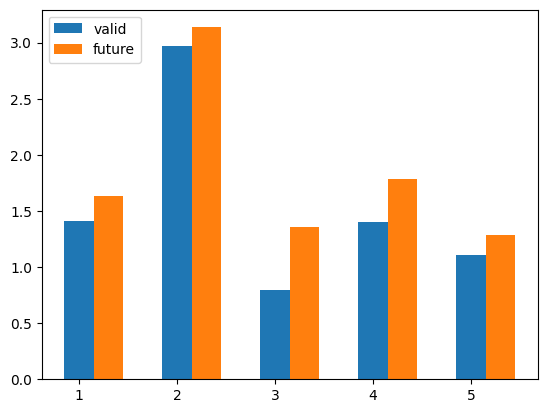

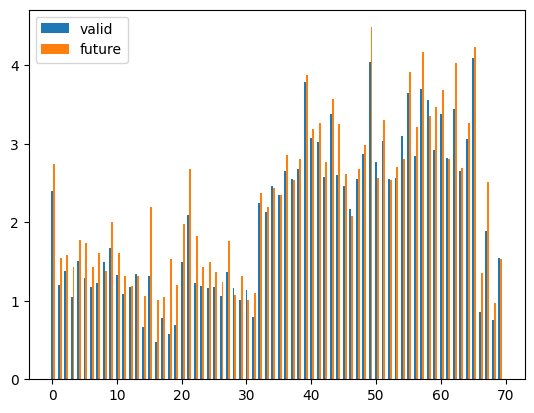

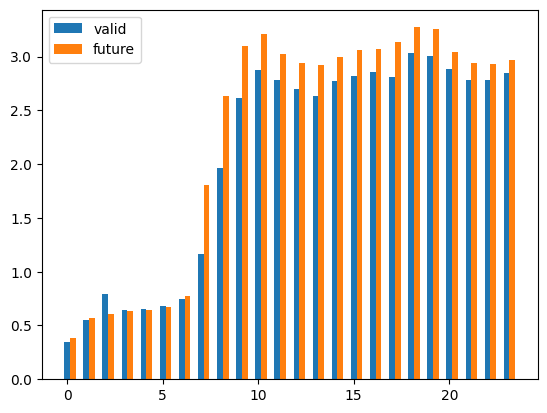

1478 8470
0 1750
18215 26250
157786 181930


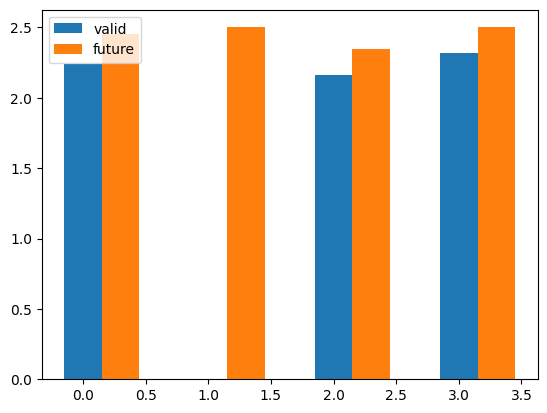

25232 36680
25372 31220
25385 39690
25163 34790
25290 28210
25302 18410
25735 29400


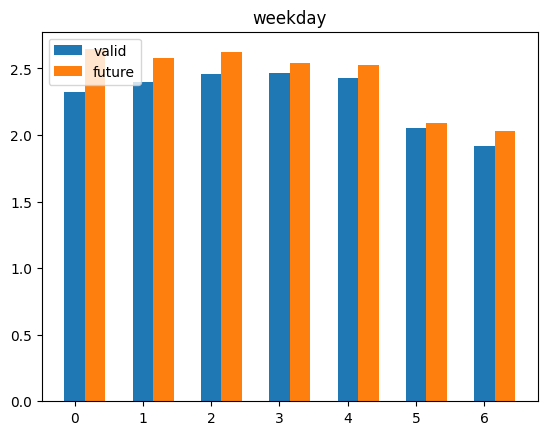

In [45]:
# valid, valid2のグラフ化
valid_predict = valid
valid_predict['bikes_available_predict'] = val_predict
valid_predict2 = valid2
valid_predict2['bikes_available_predict'] = val2_predict

# cityごとのRMSEの差分
rmse_by_city1 = []
rmse_by_city2 = []
for i in range(1, 6):
    temp1 = valid_predict[valid_predict['city'] == 'city' + str(i)]
    if len(temp1) > 0:
        rmse_by_city1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    else:
        rmse_by_city1.append(0)
    temp2 = valid_predict2[valid_predict2['city'] == 'city' + str(i)]
    if len(temp2) > 0:
        rmse_by_city2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
    else:
        rmse_by_city2.append(0)
    print(len(temp1), len(temp2))
plt.bar(range(1, 6), rmse_by_city1, width=0.3, label='valid')
plt.bar(np.array(range(1, 6)) + 0.3, rmse_by_city2, width=0.3, label='future')
plt.legend(loc=2)
plt.show()

# ステーションごとのRMSEの差分
rmse_by_station1 = []
rmse_by_station2 = []
for i in range(0, 70):
    temp1 = valid_predict[valid_predict['station_id'] == i]
    if len(temp1) > 0:
        rmse_by_station1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    else:
        rmse_by_station1.append(0)
    temp2 = valid_predict2[valid_predict2['station_id'] == i]
    if len(temp2) > 0:
        rmse_by_station2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
    else:
        rmse_by_station2.append(0)
plt.bar(range(0, 70), rmse_by_station1, width=0.3, label='valid')
plt.bar(np.array(range(0, 70)) + 0.3, rmse_by_station2, width=0.3, label='future')
plt.legend(loc=2)
plt.show()

# 時刻ごとのRMSEの差分
rmse_by_hour1 = []
rmse_by_hour2 = []
for i in range(0, 24):
    temp1 = valid_predict[valid_predict['hour'] == i]
    rmse_by_hour1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    temp2 = valid_predict2[valid_predict2['hour'] == i]
    rmse_by_hour2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
plt.bar(range(0, 24), rmse_by_hour1, width=0.3, label='valid')
plt.bar(np.array(range(0, 24)) + 0.3, rmse_by_hour2, width=0.3, label='future')
plt.legend(loc=2)
plt.show()

# 天気ごとのRMSEの差分
rmse_by_events1 = []
rmse_by_events2 = []
for i in range(0, 4):
    temp1 = valid_predict[valid_predict['events'] == i]
    if len(temp1) > 0:
        rmse_by_events1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    else:
        rmse_by_events1.append(0)
    if len(temp2) > 0:
        temp2 = valid_predict2[valid_predict2['events'] == i]
        rmse_by_events2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
    else:
        rmse_by_events1.append(0)
    print(len(temp1), len(temp2))
plt.bar(range(0, 4), rmse_by_events1, width=0.3, label='valid')
plt.bar(np.array(range(0, 4)) + 0.3, rmse_by_events2, width=0.3, label='future')
plt.legend(loc=2)
plt.show()

# 曜日ごとのRMSEの差分
rmse_by_weekday1 = []
rmse_by_weekday2 = []
for i in range(0, 7):
    temp1 = valid_predict[valid_predict['weekday'] == i]
    if len(temp1) > 0:
        rmse_by_weekday1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    else:
        rmse_by_weekday1.append(0)
    if len(temp2) > 0:
        temp2 = valid_predict2[valid_predict2['weekday'] == i]
        rmse_by_weekday2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
    else:
        rmse_by_weekday2.append(0)
    print(len(temp1), len(temp2))
plt.bar(range(0, 7), rmse_by_weekday1, width=0.3, label='valid')
plt.bar(np.array(range(0, 7)) + 0.3, rmse_by_weekday2, width=0.3, label='future')
plt.title("weekday")
plt.legend(loc=2)
plt.show()


In [21]:
# ステーション、日付ごとに折れ線
for st in range(32, 33):
    target_station = valid_predict[valid_predict['station_id'] == st]
    target_station = target_station.sort_values('date_hour')

    # 時間ごとのbikes_availableの平均
    available_by_target = []
    predict_by_target = []
    for i in range(0, 24):
        temp1 = target_station[target_station['hour'] == i]
        if len(temp1) > 0:
            available_by_target.append((temp1['bikes_available']).mean())
            predict_by_target.append((temp1['bikes_available_predict']).mean())
        else:
            available_by_target.append(0)
            predict_by_target.append(0)
    plt.bar(range(0, 24), available_by_target, width=0.3, label='available')
    plt.bar(np.array(range(0, 24)) + 0.3, predict_by_target, width=0.3, label='predict')
    plt.legend(loc=2)
    plt.title("station:" + str(st))
    plt.show()


KeyError: 'date_hour'

Text(0.5, 1.0, 'bikes_available Station:49')

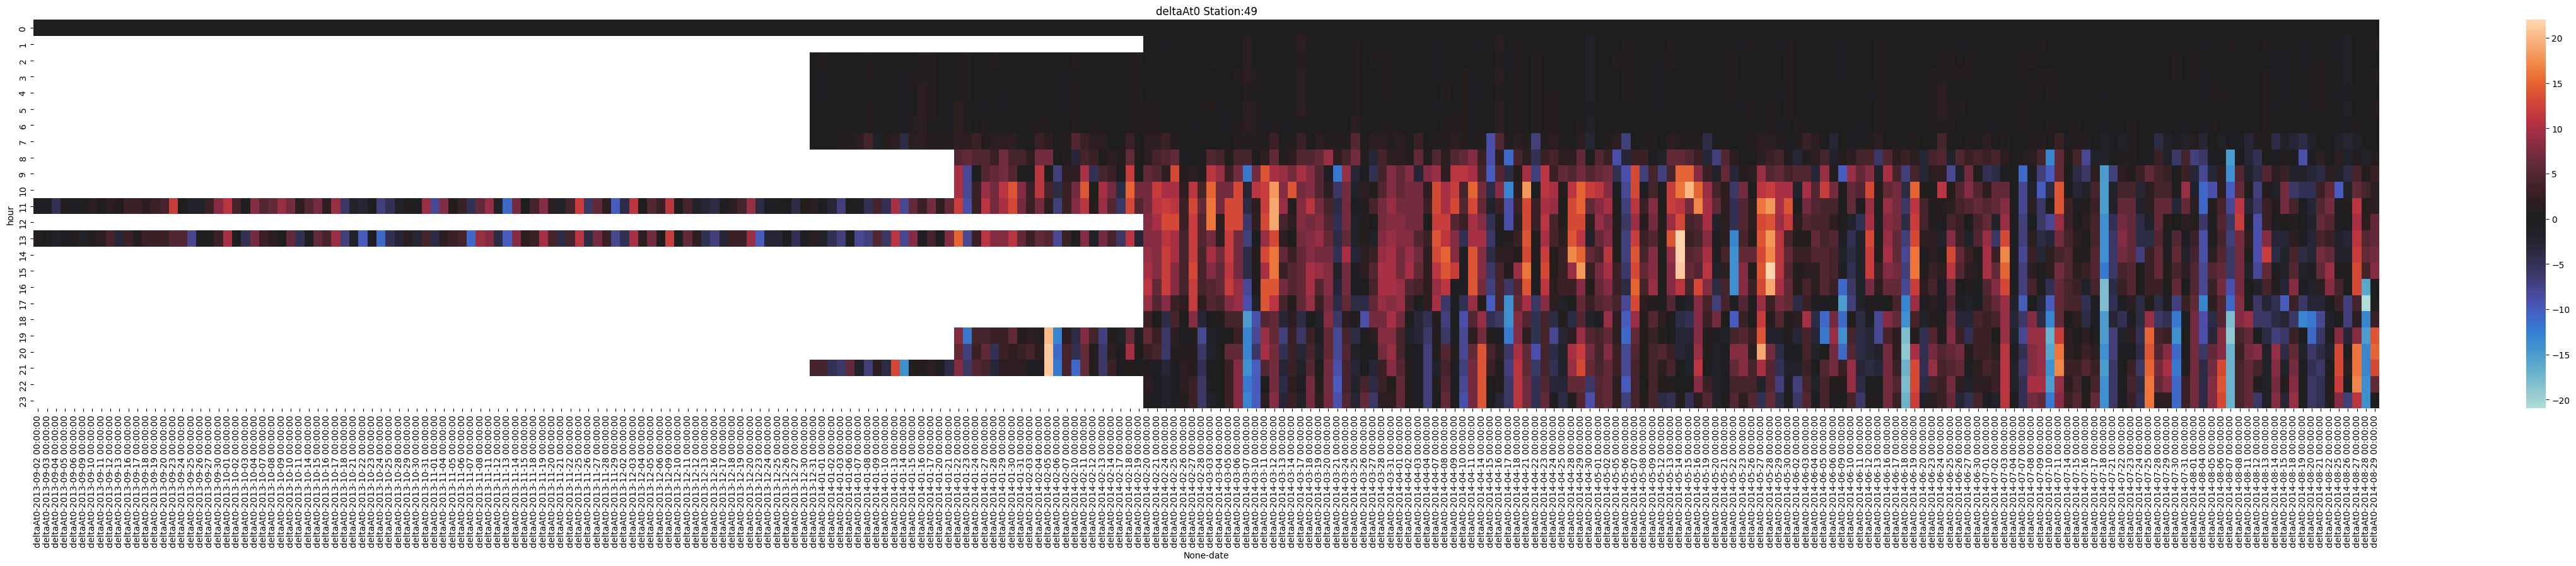

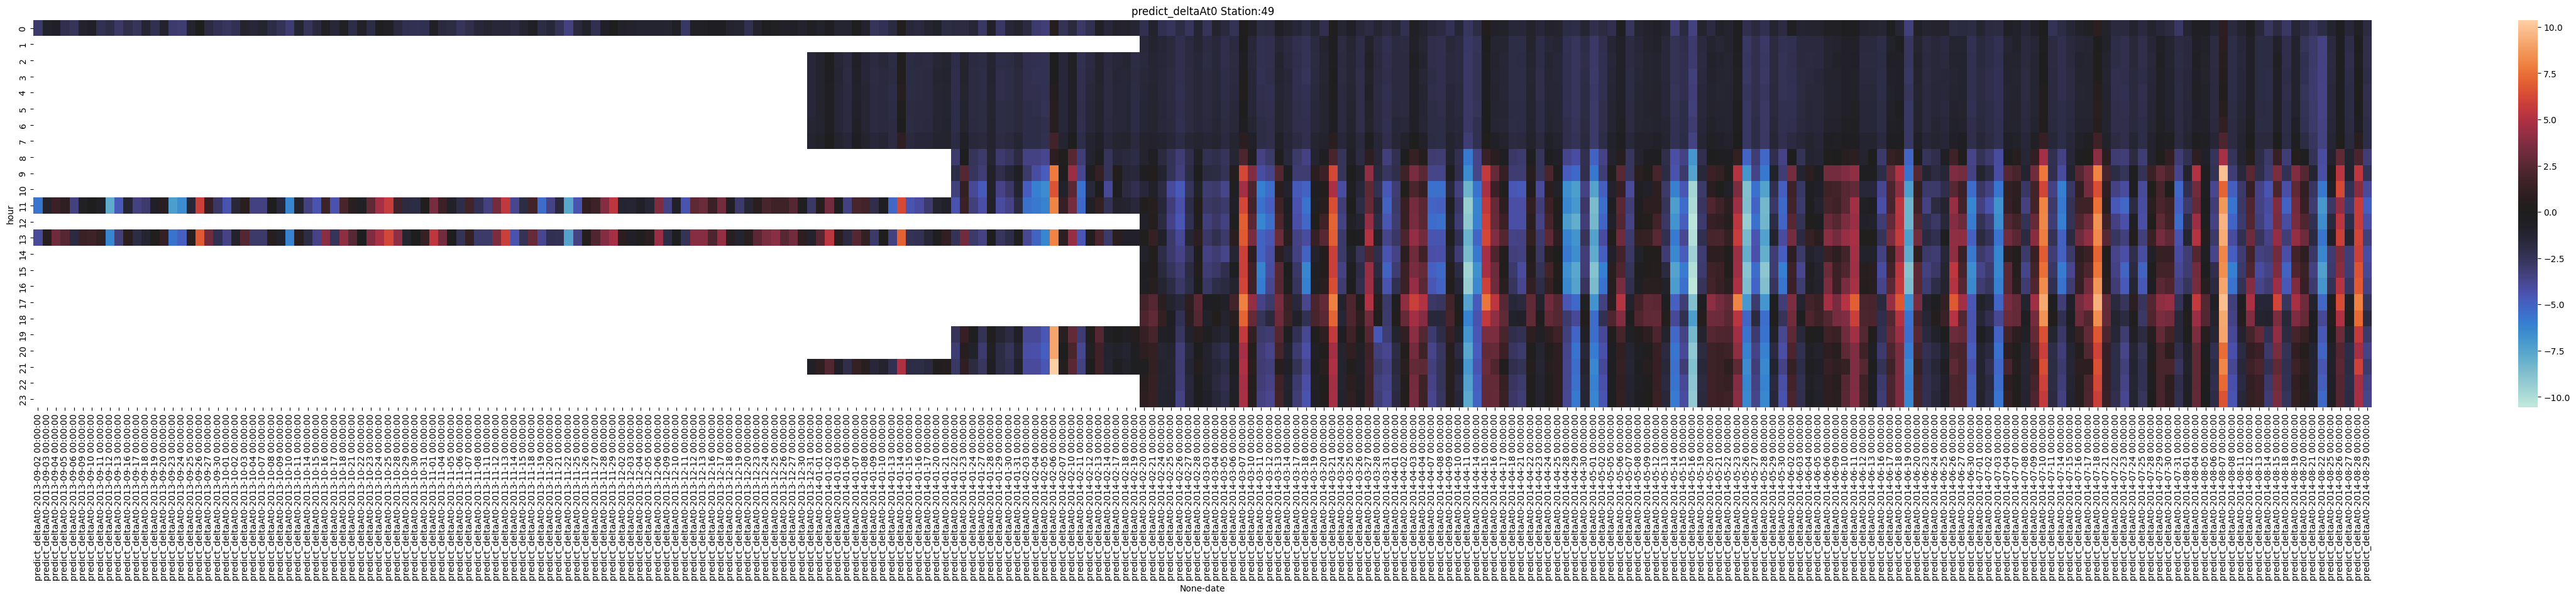

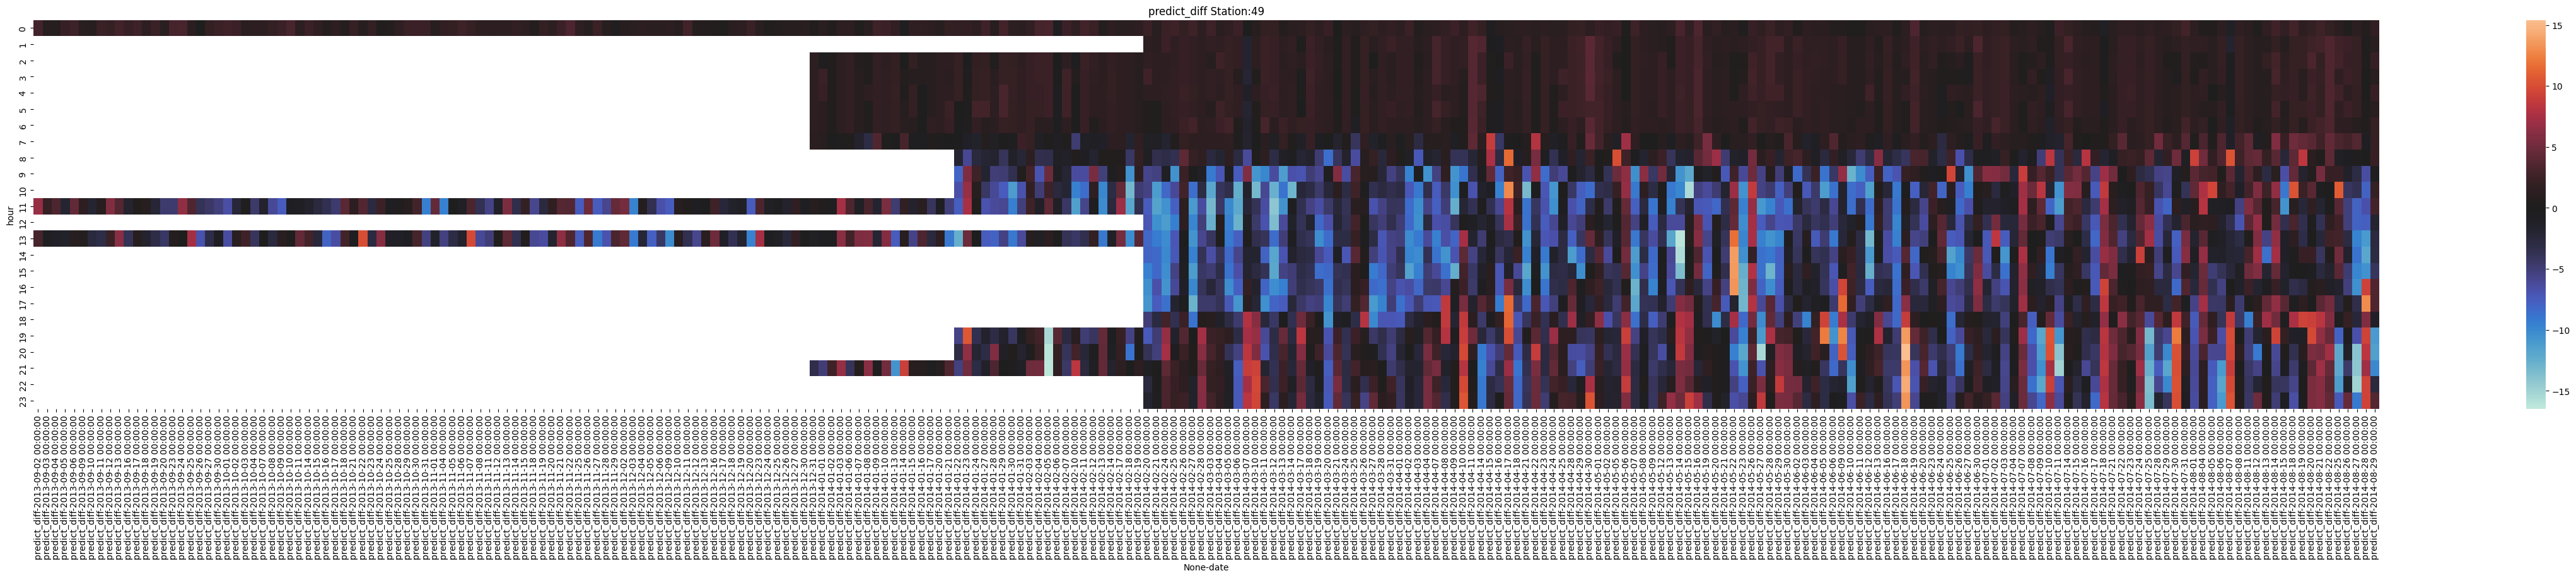

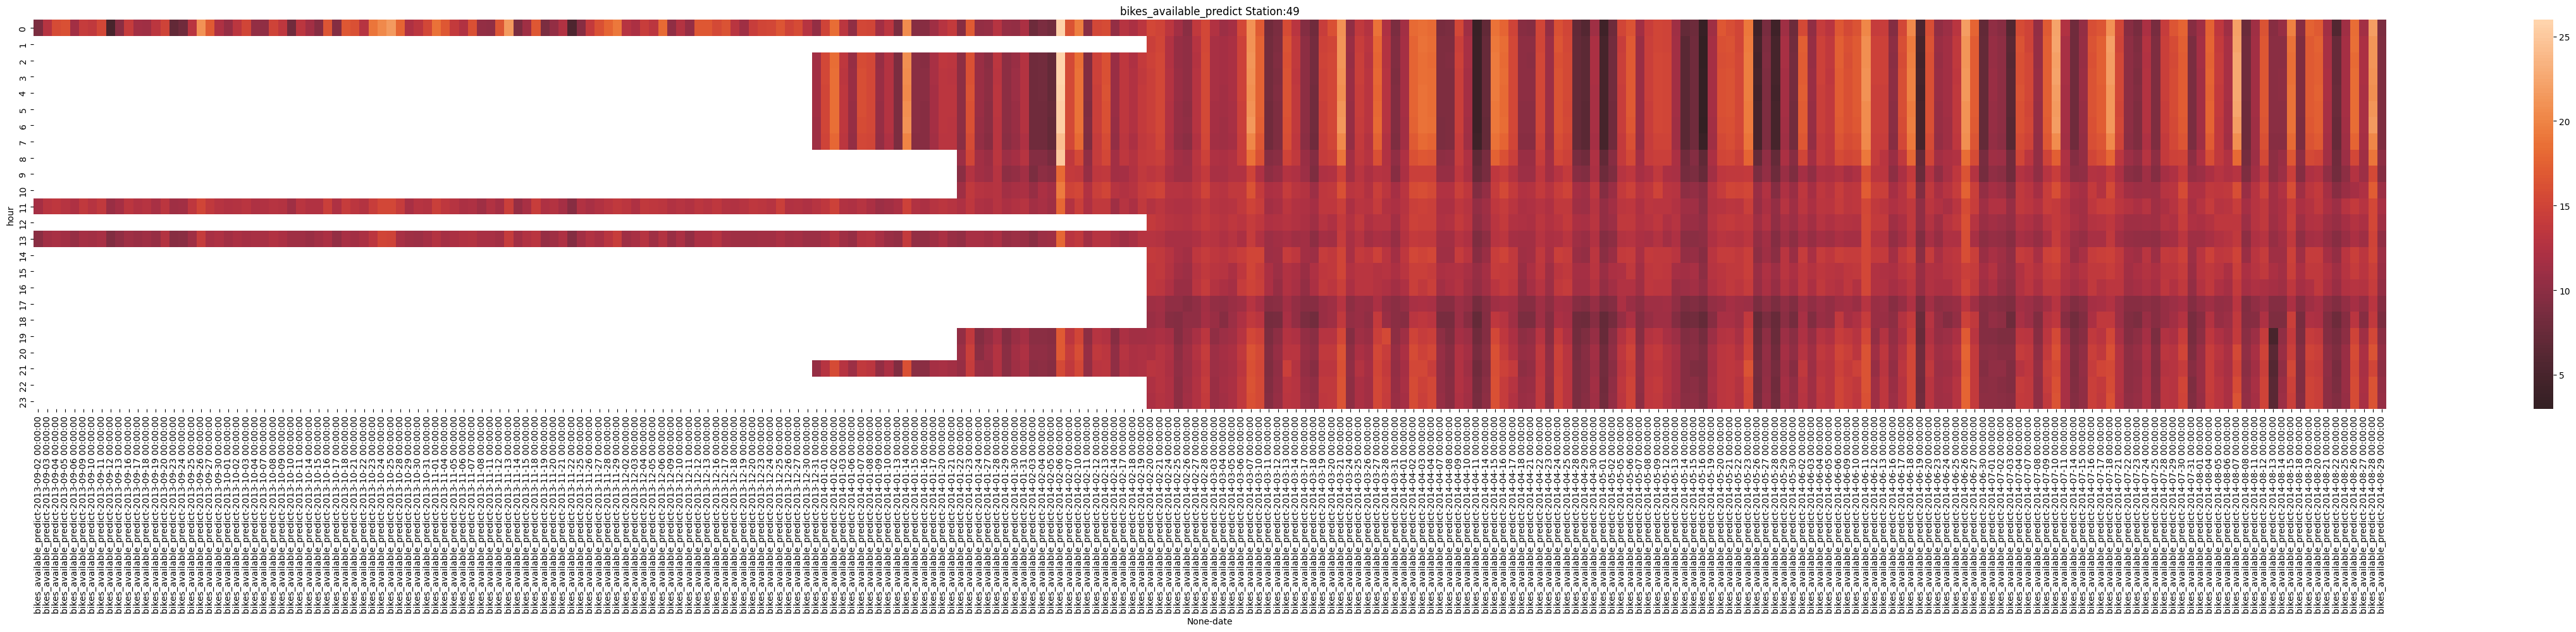

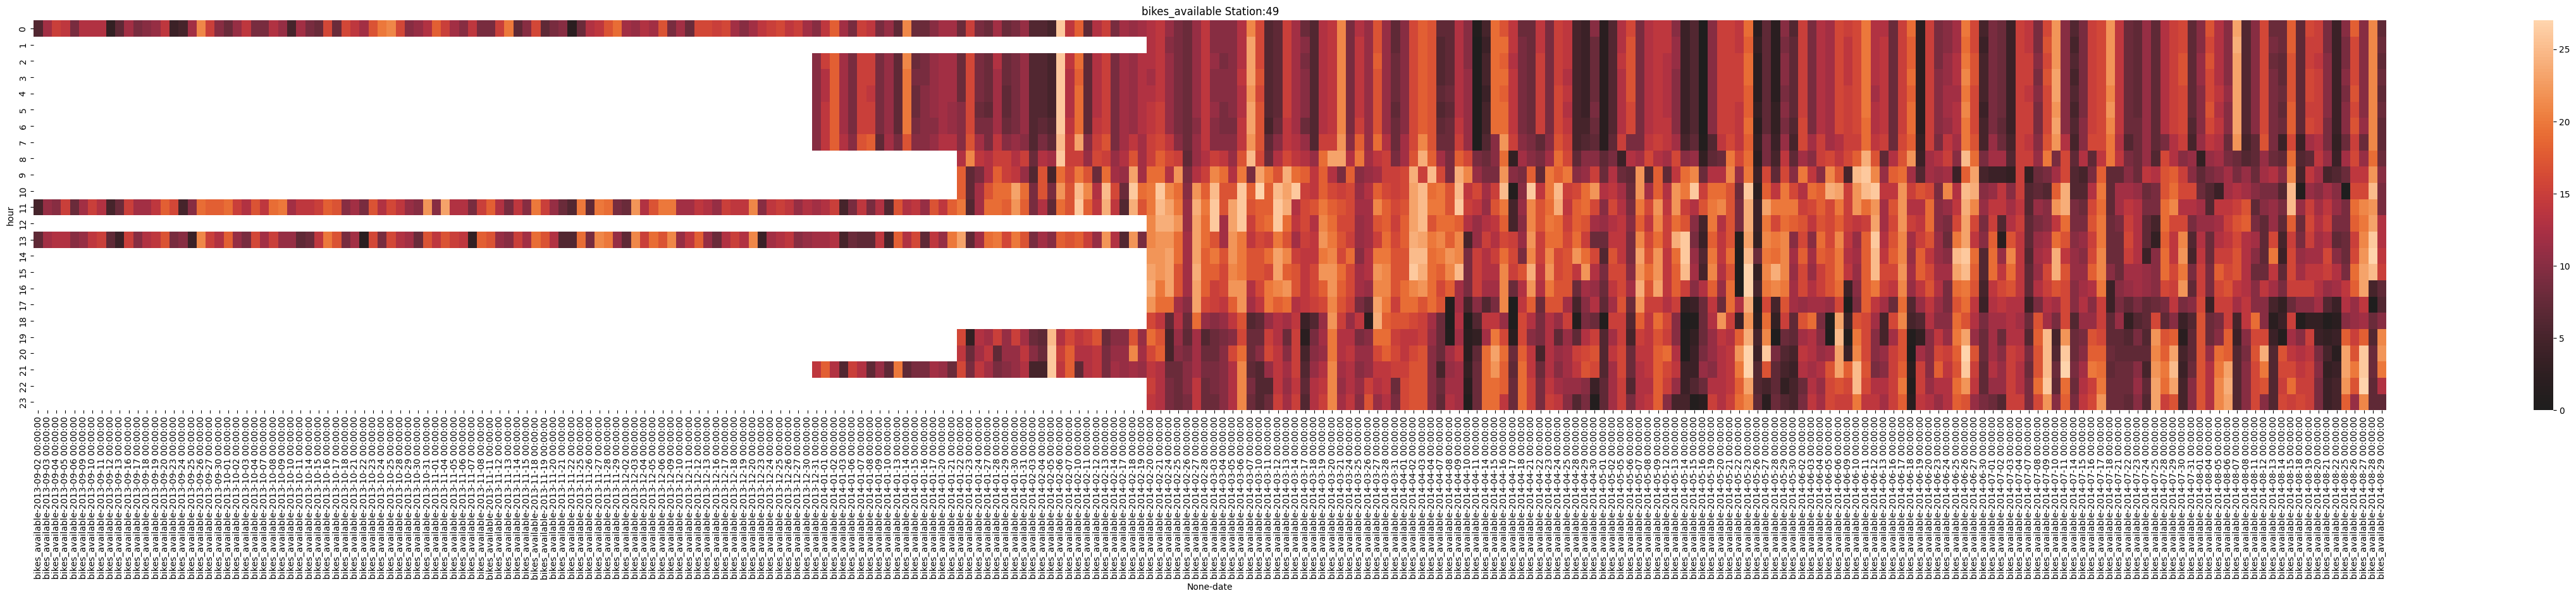

In [126]:
# ステーションごとに２４時間の差分。
sta = 49
input_result = input
input_result['bikes_available_predict'] = input_predict
input_result['predict_diff'] = input_result['bikes_available_predict'] - input_result['bikes_available']
input_result['predict_deltaAt0'] = input_result['bikes_available_at0'] - input_result['bikes_available_predict']

# 対象のステーションと曜日を絞る
input_result = input_result[input_result['station_id']==sta]
input_result = input_result[input_result['weekday'] < 5]

deltaAt0 = input_result[['date','hour','deltaAt0']]
deltaAt0 = pd.pivot_table(data=deltaAt0, columns='date', index='hour')
plt.figure(figsize=(60, 8))
p = sns.heatmap(deltaAt0, center = 0)
p.set_title("deltaAt0 Station:" + str(sta))

predict_deltaAt0 = input_result[['date','hour','predict_deltaAt0']]
predict_deltaAt0 = pd.pivot_table(data=predict_deltaAt0, columns='date', index='hour')
plt.figure(figsize=(60, 8))
p = sns.heatmap(predict_deltaAt0, center = 0)
p.set_title("predict_deltaAt0 Station:" + str(sta))

predict_diff = input_result[['date','hour','predict_diff']]
predict_diff = pd.pivot_table(data=predict_diff, columns='date', index='hour')
plt.figure(figsize=(60, 8))
p = sns.heatmap(predict_diff, center = 0)
p.set_title("predict_diff Station:" + str(sta))

available_predict = input_result[['date','hour','bikes_available_predict']]
available_predict = pd.pivot_table(data=available_predict, columns='date', index='hour')
plt.figure(figsize=(60, 8))
p = sns.heatmap(available_predict, center = 0)
p.set_title("bikes_available_predict Station:" + str(sta))

bikes_available = input_result[['date','hour','bikes_available']]
bikes_available = pd.pivot_table(data=bikes_available, columns='date', index='hour')
plt.figure(figsize=(60, 8))
p = sns.heatmap(bikes_available, center = 0)
p.set_title("bikes_available Station:" + str(sta))



In [96]:
# ステーションごとの差分が分析できてないイメージか。
# 差が大きいステーション49を詳しく見てみる
target_station = valid_predict[valid_predict['station_id'] == 32]
# 予測と実際の差分
target_station['bikes_available_diff'] = target_station['bikes_available_predict'] - target_station['bikes_available']
target_station = target_station.sort_values('date_hour')

# 時間ごとのRMSEの差分
rmse_by_target1 = []
for i in range(0, 24):
    temp1 = target_station[target_station['hour'] == i]
    if len(temp1) > 0:
        rmse_by_target1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    else:
        rmse_by_target1.append(0)
plt.bar(range(0, 24), rmse_by_target1, width=0.3, label='valid')
plt.title("station 49")
plt.show()

for i in range(0, 24):
    target = target_station[target_station['hour'] == i]
    target = target[target['weekday'] < 5]
    p0 = plt.plot(target['date_hour'], target['bikes_available_at0'], linestyle="solid")
    p1 = plt.plot(target['date_hour'], target['bikes_available'], linestyle="solid")
    p2 = plt.plot(target['date_hour'], target['bikes_available_predict'], linestyle="solid")
    p3 = plt.plot(target['date_hour'], target['bikes_available_diff'], linestyle="solid")
    plt.title("Weekday Hour:" + str(i))
    plt.legend((p0[0], p1[0], p2[0], p3[0]), ("bikes_available_at0", "bikes_available", "predict", "diff"), loc=2)
    plt.show()

for i in range(0, 24):
    target = target_station[target_station['hour'] == i]
    target = target[target['weekday'] > 4]
    p0 = plt.plot(target['date_hour'], target['bikes_available_at0'], linestyle="solid")
    p1 = plt.plot(target['date_hour'], target['bikes_available'], linestyle="solid")
    p2 = plt.plot(target['date_hour'], target['bikes_available_predict'], linestyle="solid")
    p3 = plt.plot(target['date_hour'], target['bikes_available_diff'], linestyle="solid")
    plt.title("Holiday Hour:" + str(i))
    plt.legend((p0[0], p1[0], p2[0], p3[0]), ("bikes_available_at0", "bikes_available", "predict", "diff"), loc=2)
    plt.show()

C:\Users\paser\AppData\Local\Temp\ipykernel_24488\1881220572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_station['bikes_available_diff'] = target_station['bikes_available_predict'] - target_station['bikes_available']


KeyError: 'date_hour'

C:\Users\B007576\AppData\Local\Temp\ipykernel_20648\4279040392.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_station['bikes_used'] = target_station['bikes_available_at0'] - target_station['bikes_available']
C:\Users\B007576\AppData\Local\Temp\ipykernel_20648\4279040392.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_station['bikes_used_predict'] = target_station['bikes_available_at0'] - target_station['bikes_available_predict']
C:\Users\B007576\AppData\Local\Temp\ipykernel_20648\4279

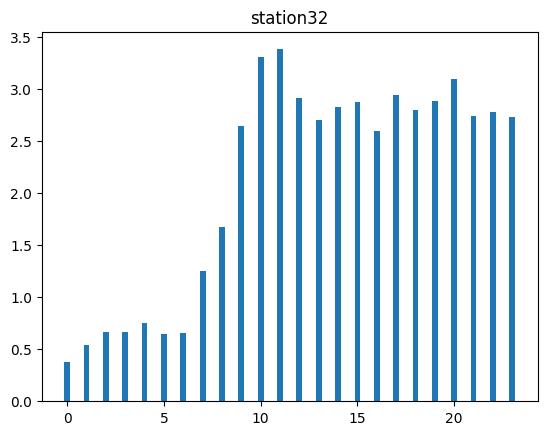

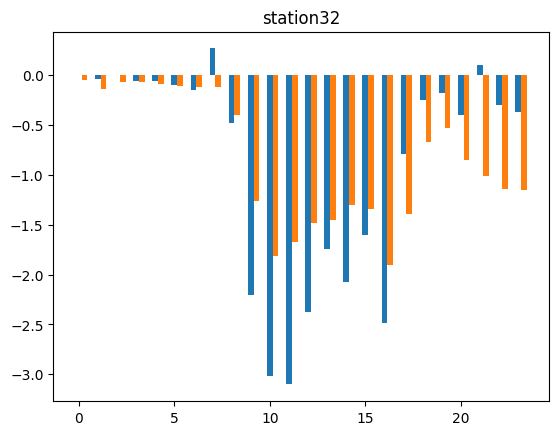

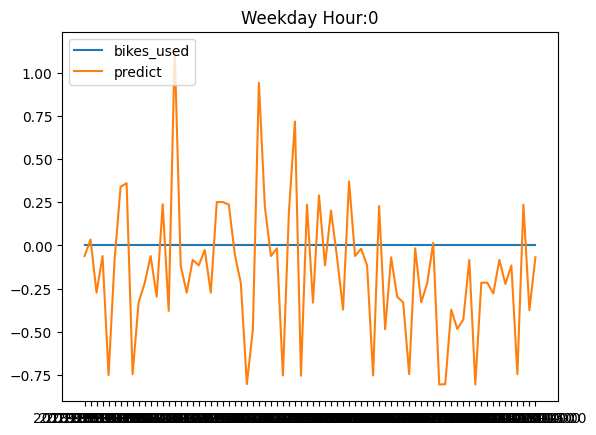

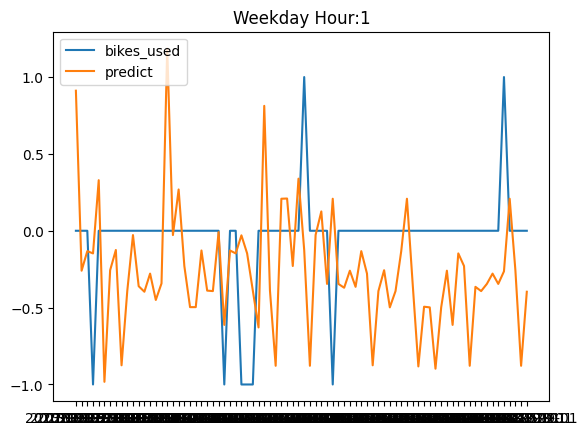

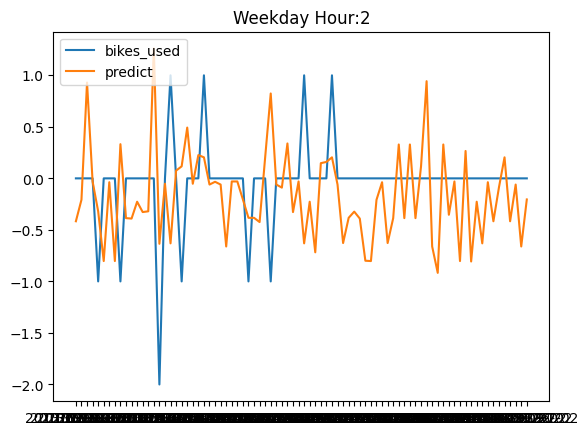

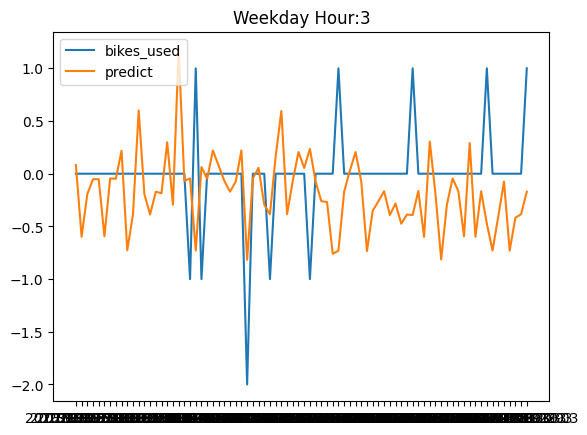

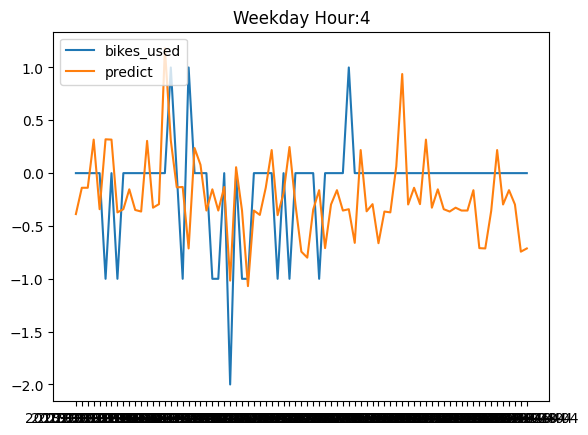

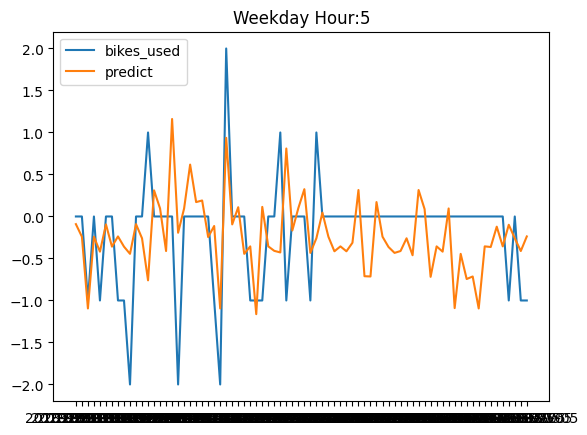

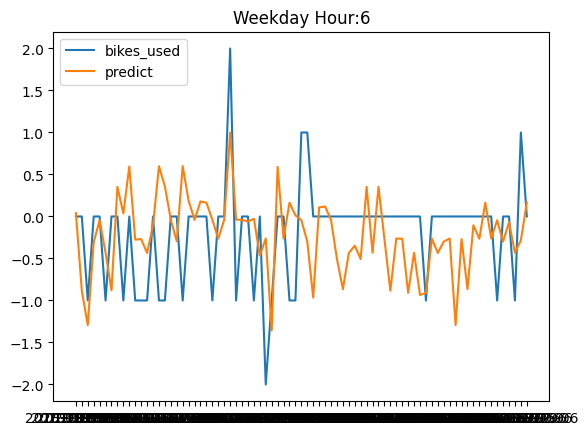

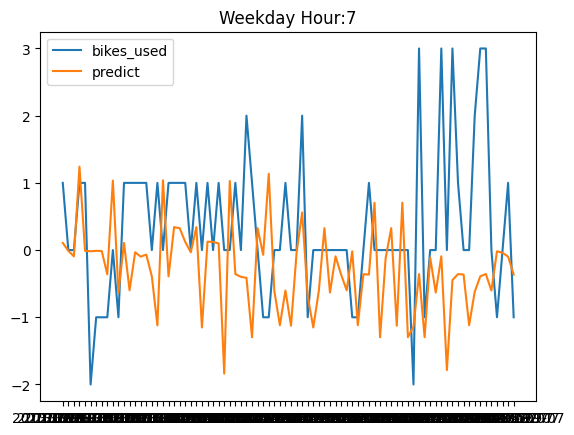

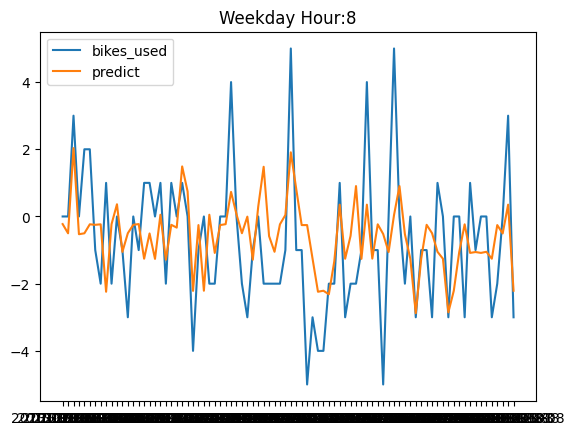

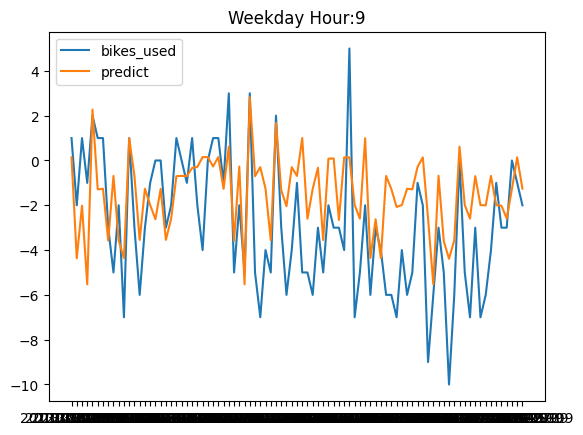

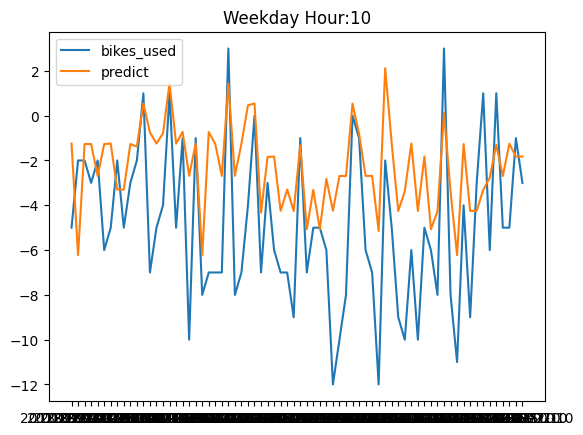

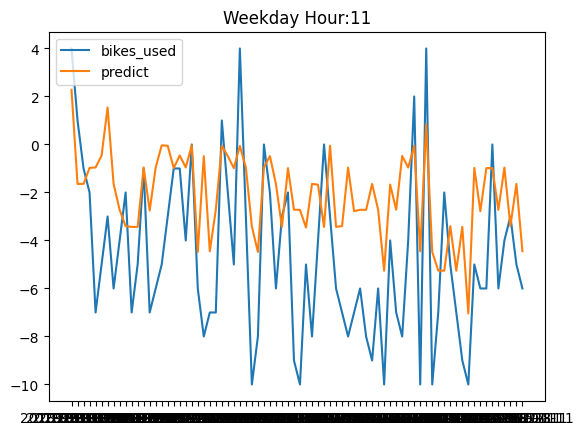

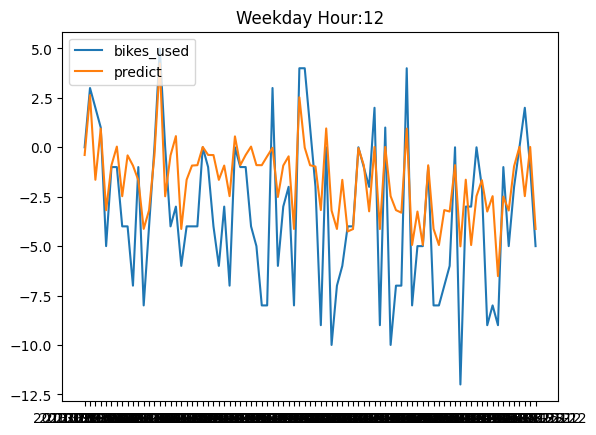

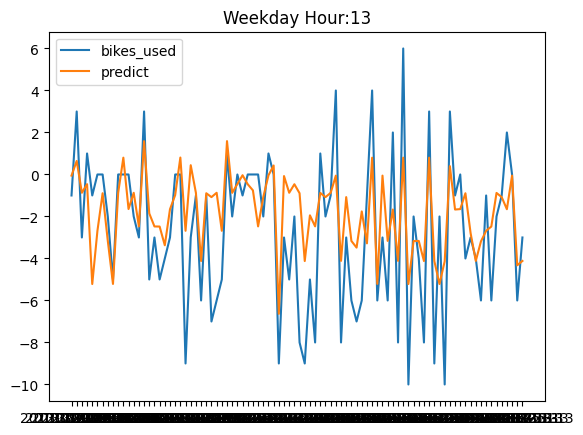

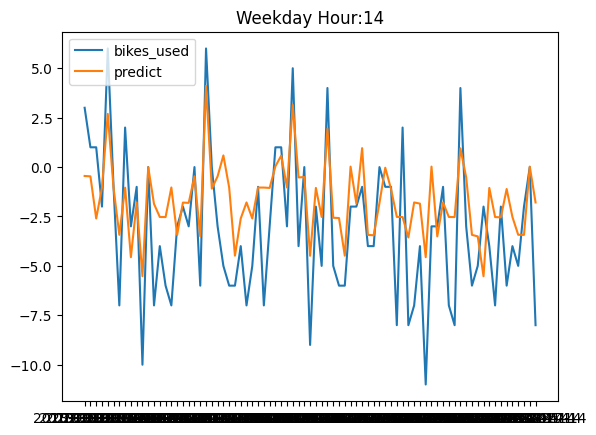

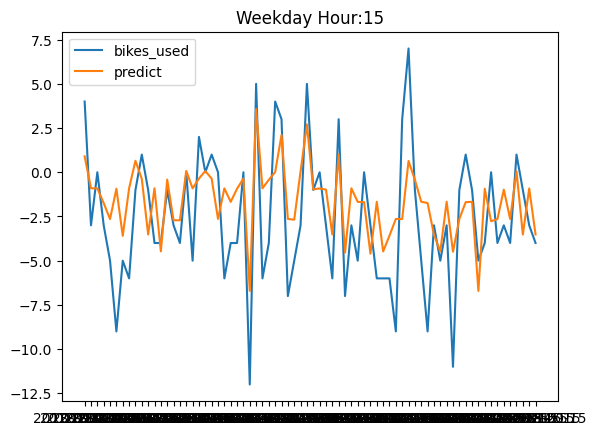

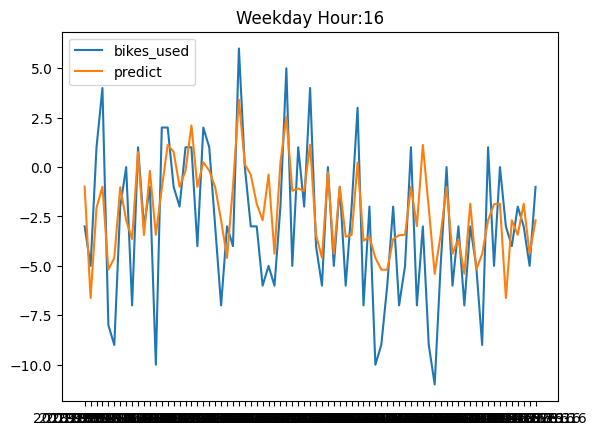

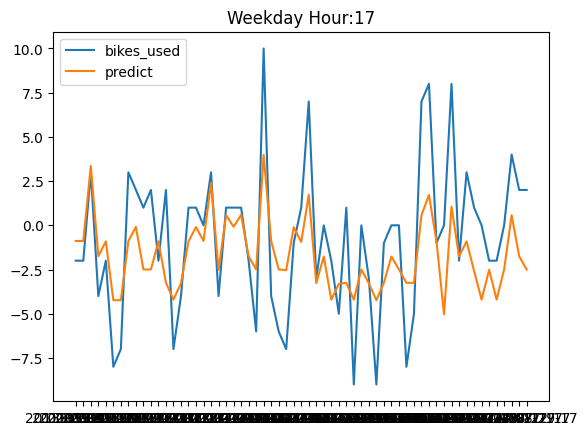

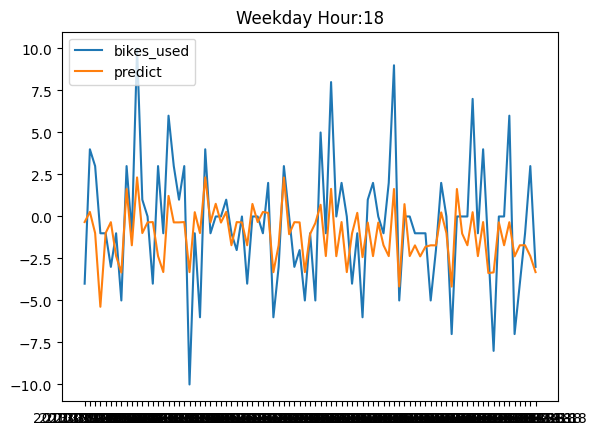

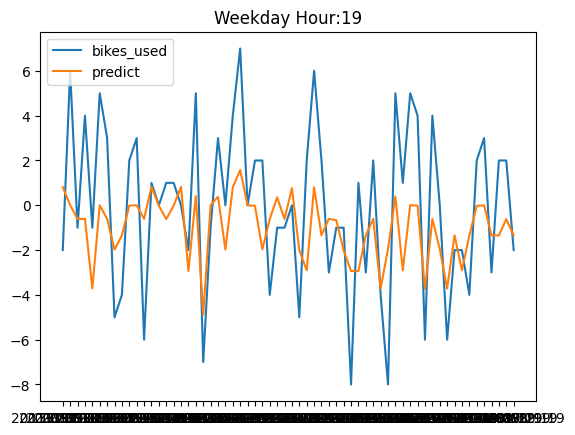

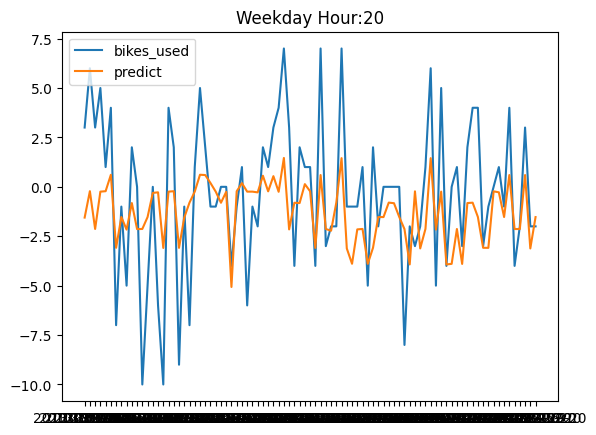

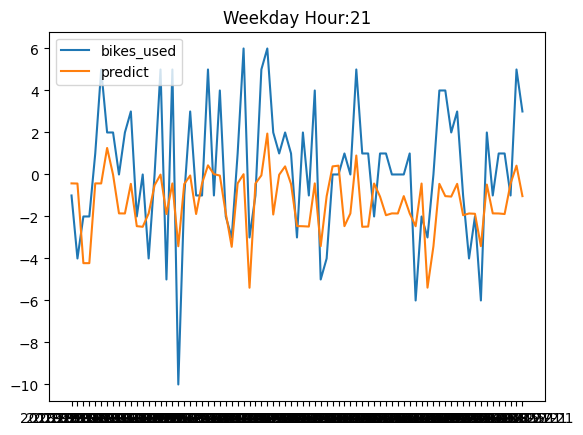

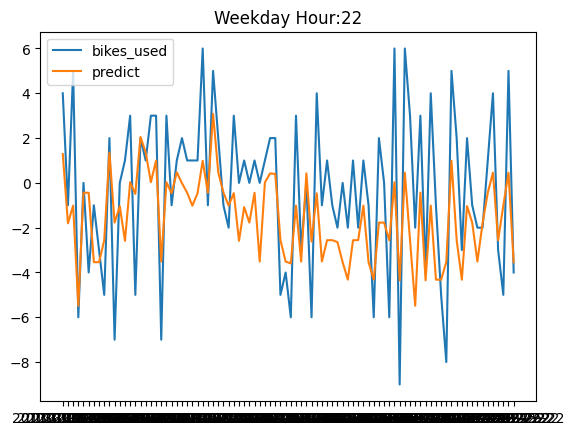

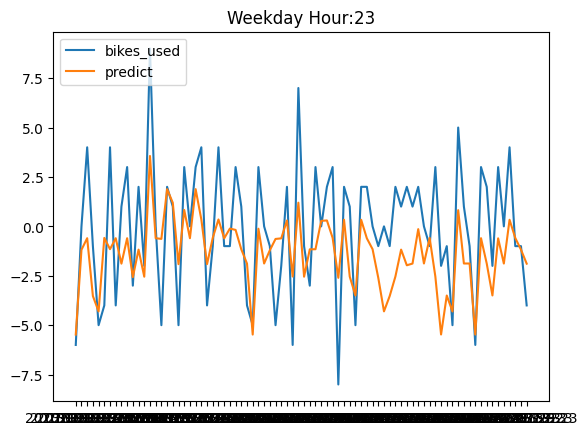

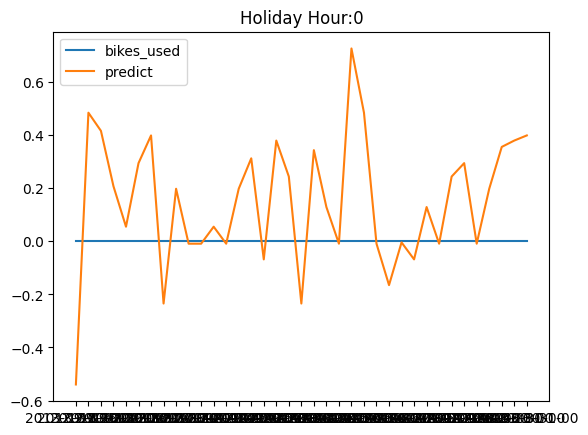

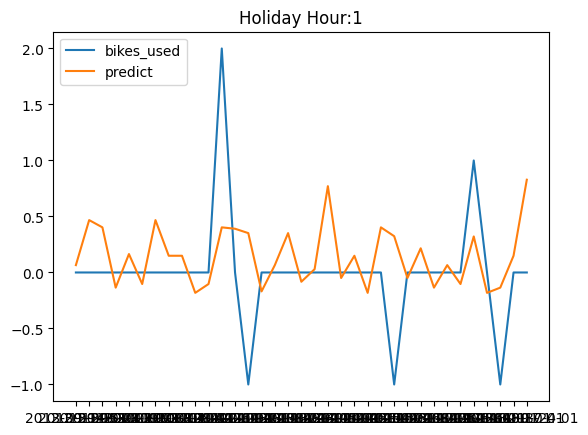

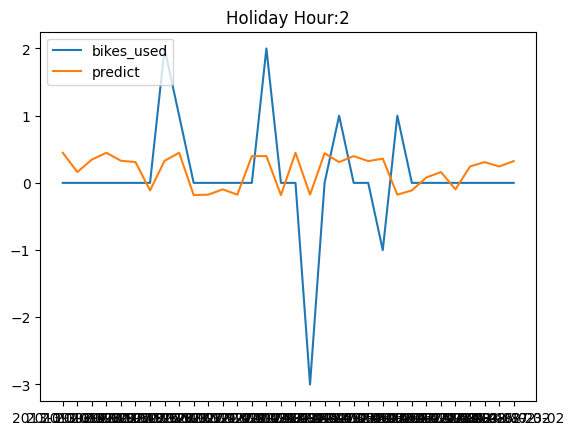

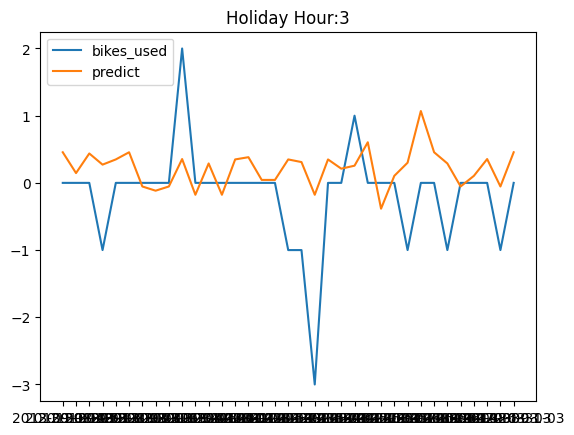

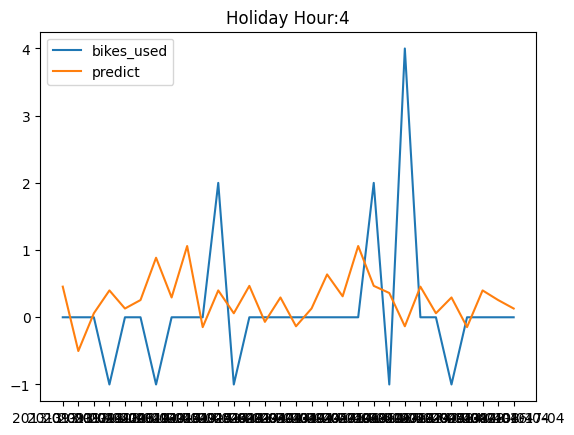

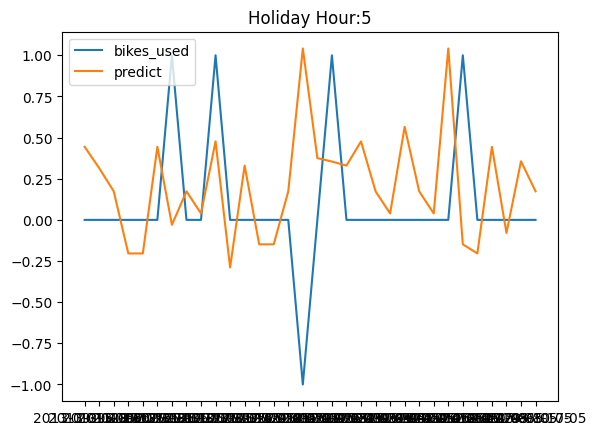

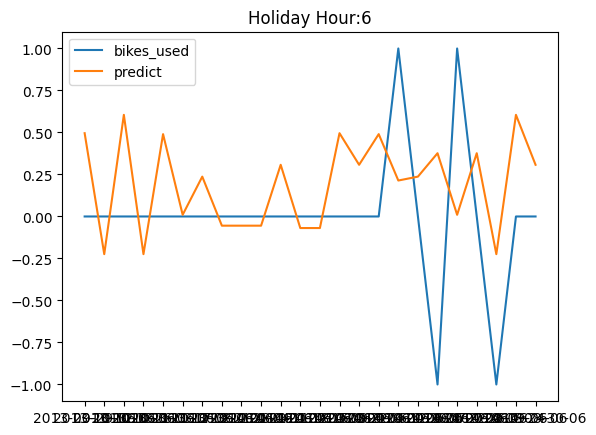

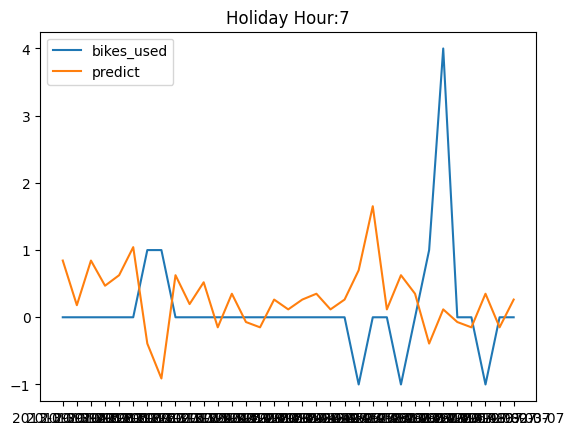

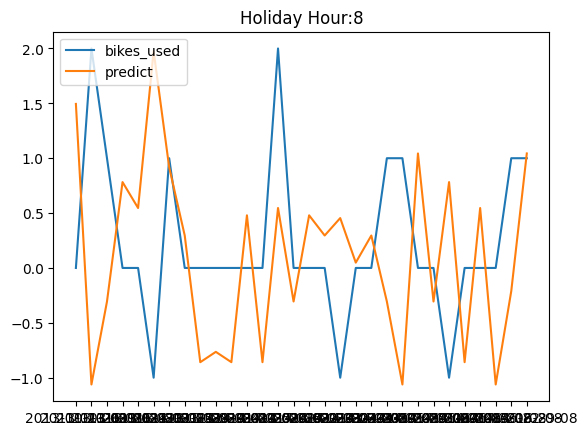

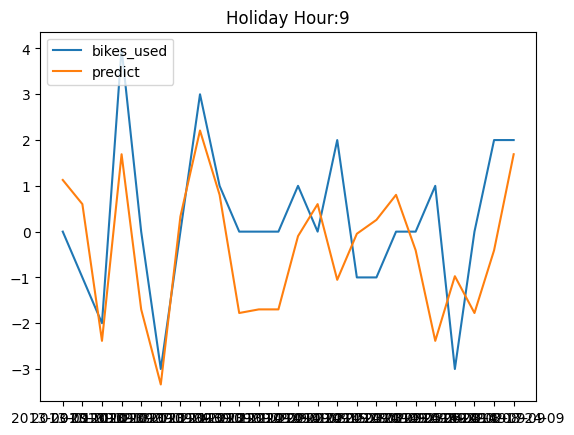

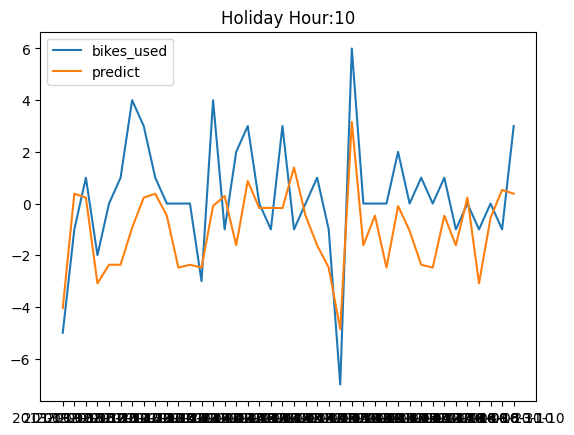

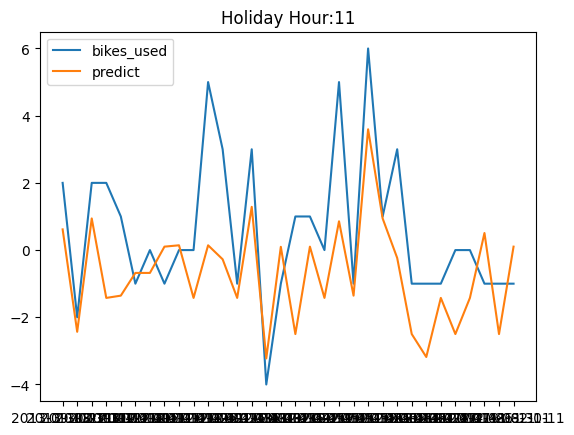

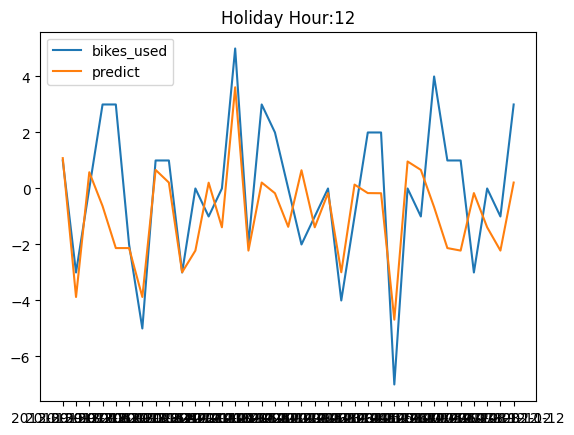

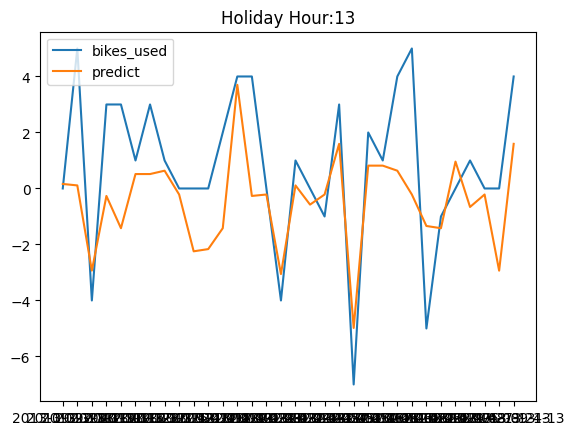

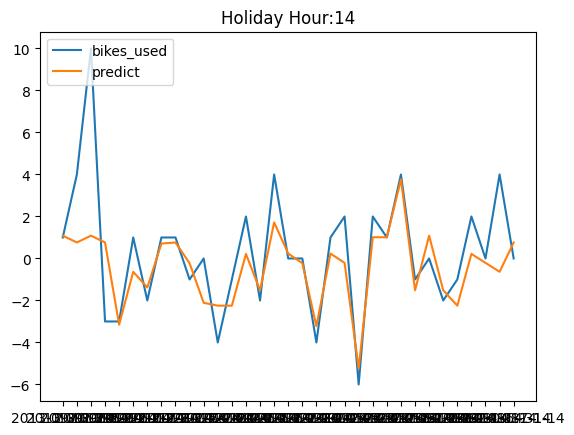

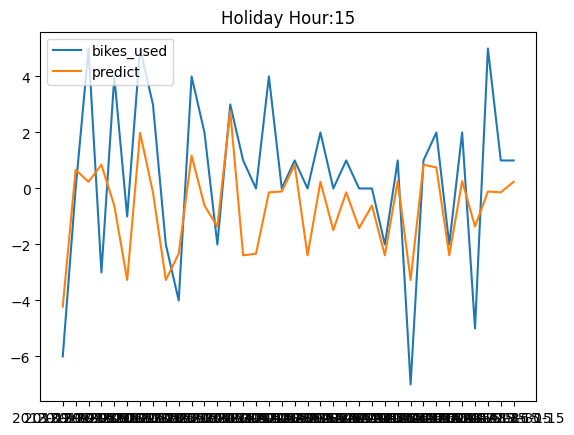

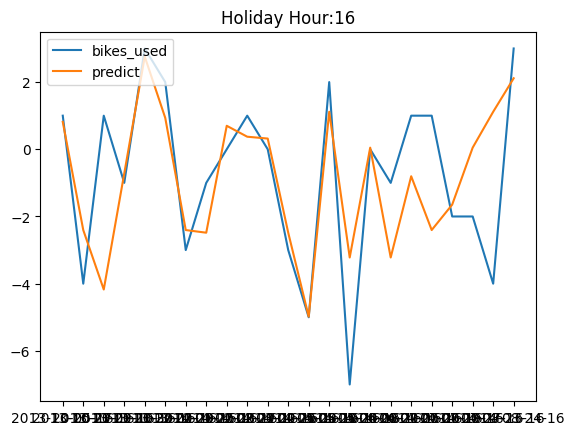

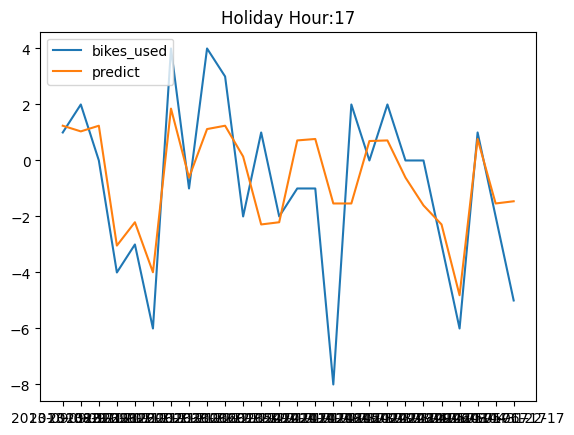

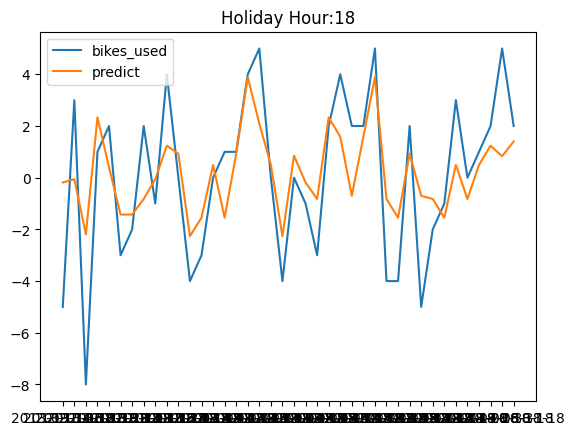

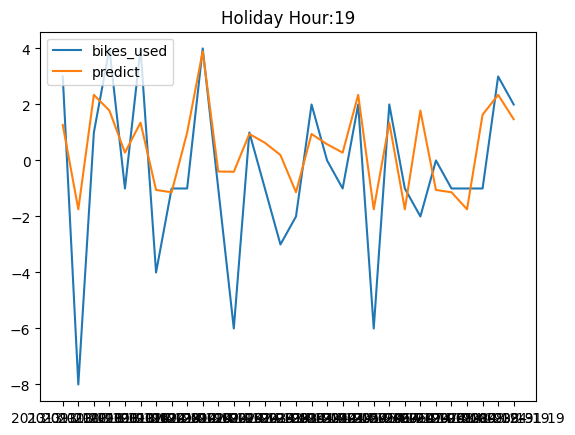

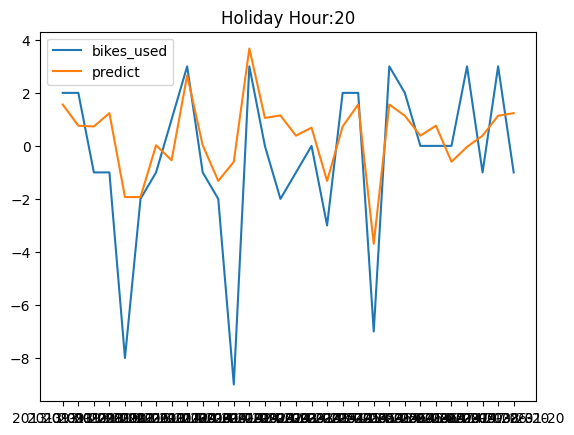

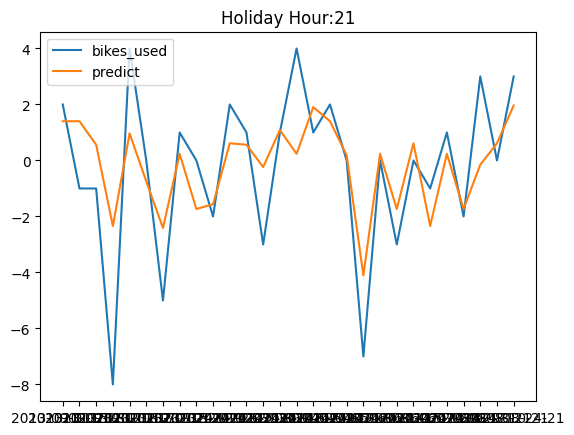

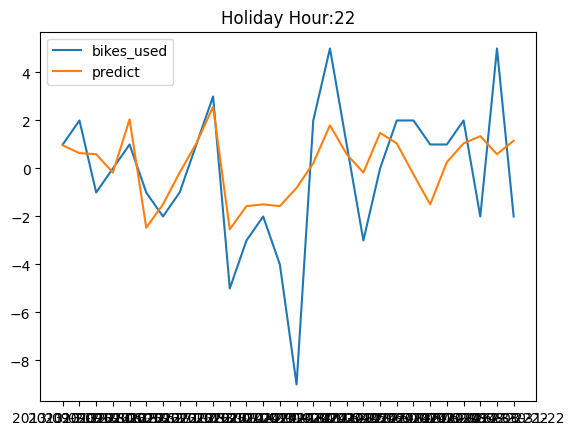

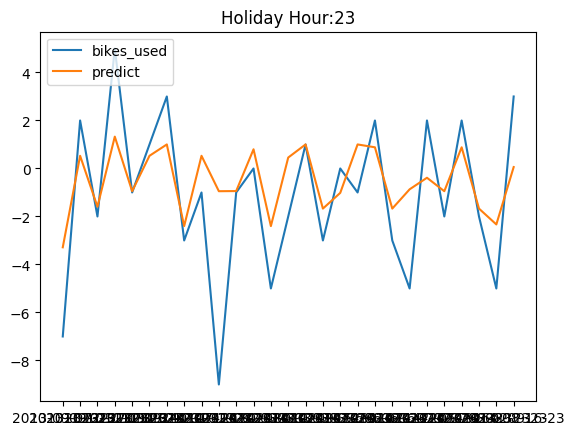

In [147]:
# ステーションごとの差分が分析できてないイメージか。
# 差が大きいステーション49を詳しく見てみる
sta = 32
target_station = valid_predict[valid_predict['station_id'] == sta]
# 予測と実際の差分
target_station['bikes_used'] = target_station['bikes_available_at0'] - target_station['bikes_available']
target_station['bikes_used_predict'] = target_station['bikes_available_at0'] - target_station['bikes_available_predict']
target_station['bikes_used_diff'] = target_station['bikes_used_predict'] - target_station['bikes_used']
target_station = target_station.sort_values('date_hour')

# 時間ごとのRMSEの差分
rmse_by_target1 = []
for i in range(0, 24):
    temp1 = target_station[target_station['hour'] == i]
    if len(temp1) > 0:
        rmse_by_target1.append(mean_squared_error(temp1['bikes_used'], temp1['bikes_used_predict'], squared=False))
    else:
        rmse_by_target1.append(0)
plt.bar(range(0, 24), rmse_by_target1, width=0.3, label='valid')
plt.title("station" + str(sta))
plt.show()

# 時間ごとの値の平均
mean_by_target1 = []
mean_by_target2 = []
for i in range(0, 24):
    temp1 = target_station[target_station['hour'] == i]
    if len(temp1) > 0:
        mean_by_target1.append(temp1['bikes_used'].mean())
        mean_by_target2.append(temp1['bikes_used_predict'].mean())
    else:
        mean_by_target1.append(0)
        mean_by_target2.append(0)
plt.bar(range(0, 24), mean_by_target1, width=0.3, label='available_mean')
plt.bar(np.array(range(0, 24)) + 0.3, mean_by_target2, width=0.3, label='predict_mean')
plt.title("station" + str(sta))
plt.show()


for i in range(0, 24):
    target = target_station[target_station['hour'] == i]
    target = target[target['weekday'] < 5]
    p1 = plt.plot(target['date_hour'], target['bikes_used'], linestyle="solid")
    p2 = plt.plot(target['date_hour'], target['bikes_used_predict'], linestyle="solid")
    plt.title("Weekday Hour:" + str(i))
    plt.legend((p1[0], p2[0]), ("bikes_used", "predict"), loc=2)
    plt.show()

for i in range(0, 24):
    target = target_station[target_station['hour'] == i]
    target = target[target['weekday'] > 4]
    p1 = plt.plot(target['date_hour'], target['bikes_used'], linestyle="solid")
    p2 = plt.plot(target['date_hour'], target['bikes_used_predict'], linestyle="solid")
    plt.title("Holiday Hour:" + str(i))
    plt.legend((p1[0], p2[0]), ("bikes_used", "predict"), loc=2)
    plt.show()

39765 49920
90956 109200
16974 21840
16531 21840
13234 15600


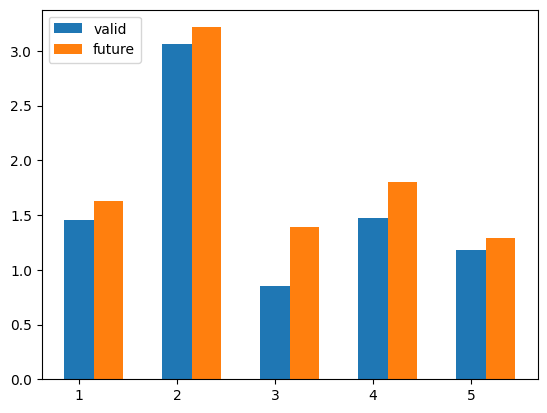

In [148]:
# cityごとのRMSEの差分
rmse_by_city1 = []
rmse_by_city2 = []
for i in range(1, 6):
    temp1 = valid_predict[valid_predict['city'] == 'city' + str(i)]
    rmse_by_city1.append(mean_squared_error(temp1['bikes_available'], temp1['bikes_available_predict'], squared=False))
    temp2 = valid_predict2[valid_predict2['city'] == 'city' + str(i)]
    rmse_by_city2.append(mean_squared_error(temp2['bikes_available'], temp2['bikes_available_predict'], squared=False))
    print(len(temp1), len(temp2))
plt.bar(range(1, 6), rmse_by_city1, width=0.3, label='valid')
plt.bar(np.array(range(1, 6)) + 0.3, rmse_by_city2, width=0.3, label='future')
plt.legend(loc=2)
plt.show()
